# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 100

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
IMAGES_PATH

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### 2.3 Load Image into TF Data Pipeline

In [ ]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [ ]:
images.as_numpy_iterator().next()

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [8]:
import albumentations as alb

In [ ]:
img = cv2.imread(r"data\train\images\9ccbb8ab-9120-11ee-90a2-dc7196feb86f.jpg")

In [ ]:
img.shape

In [9]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
img = cv2.imread(r"data\train\images\9ccbb8ab-9120-11ee-90a2-dc7196feb86f.jpg")

In [ ]:
img

In [ ]:
with open(os.path.join('data', 'train', 'labels', '9ccbb8ab-9120-11ee-90a2-dc7196feb86f.json'), 'r') as f:
    label = json.load(f)

In [ ]:
label

In [ ]:
type(label)

In [ ]:
label['shapes'][0]['points']

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

In [ ]:
coords = list(np.divide(coords, [640,480,640,480]))

In [ ]:
coords

### 4.4 Apply Augmentations and View Results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented

In [ ]:
augmented['bboxes'][0][2:]

In [ ]:
augmented['bboxes']

In [ ]:
augmented["image"].shape

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (0,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [10]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [11]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [12]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [13]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [14]:
train_images.as_numpy_iterator().next()

array([[[0.40398285, 0.25545344, 0.2608456 ],
        [0.4126838 , 0.2502451 , 0.26446077],
        [0.41145834, 0.2624387 , 0.25422794],
        ...,
        [0.30643383, 0.1481005 , 0.109375  ],
        [0.2803309 , 0.10435049, 0.07935049],
        [0.25159314, 0.08878677, 0.07506128]],

       [[0.35557598, 0.23204657, 0.2286152 ],
        [0.39846814, 0.24405637, 0.25545344],
        [0.3795343 , 0.22610295, 0.23002452],
        ...,
        [0.2754902 , 0.11819853, 0.08682598],
        [0.3064951 , 0.13786764, 0.11090686],
        [0.2528186 , 0.10955882, 0.07849265]],

       [[0.39767158, 0.25324756, 0.26207107],
        [0.37996325, 0.21035539, 0.23682599],
        [0.39669117, 0.23241422, 0.24810049],
        ...,
        [0.31629902, 0.1555147 , 0.13982843],
        [0.29871324, 0.12616421, 0.11439951],
        [0.29577205, 0.1408701 , 0.11439951]],

       ...,

       [[0.21011029, 0.07450981, 0.06764706],
        [0.2112745 , 0.06862745, 0.07696079],
        [0.22800244, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [16]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [19]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6900, 6900, 1560, 1560, 2280, 2280)

### 7.2 Create Final Datasets (Images/Labels)

In [20]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [21]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [22]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [23]:
train.as_numpy_iterator().next()[1]

KeyboardInterrupt: 

In [ ]:
train.as_numpy_iterator().next()[0].shape
#0 for image, 1 for label

### 7.3 View Images and Annotations

In [24]:
data_samples = train.as_numpy_iterator()

In [25]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


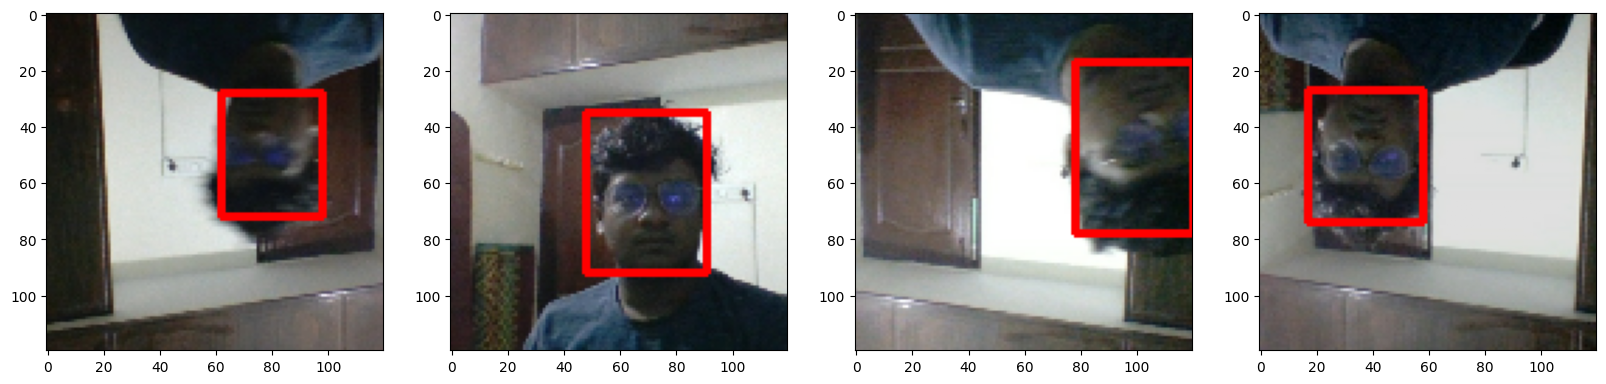

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [28]:
vgg = VGG16(include_top=False)

In [30]:
vgg.trainable=False

In [38]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [43]:
vgg.trainable=True
for layer in vgg.layers[:-5]:
    layer.trainable=False

In [44]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [74]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)
    vgg.trainable=True
    for layer in vgg.layers[:-5]:
        layer.trainable=False

    x = vgg(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(x)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid', dtype=tf.float32)(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(x)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid', dtype=tf.float32)(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [75]:
facetracker = build_model()

In [76]:
facetracker.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_12[0][0]']               
                                512)                                                              
                                                                                                  
 global_max_pooling2d_10 (Globa  (None, 512)         0           ['vgg16[0][0]']                  
 lMaxPooling2D)                                                                             

In [77]:
for layer in facetracker.layers[1:]:
    print(layer.name, layer.trainable)

vgg16 True
global_max_pooling2d_10 True
global_max_pooling2d_11 True
dense_20 True
dense_22 True
dense_21 True
dense_23 True


In [78]:
vgg.trainable

True

In [79]:
X, y = train.as_numpy_iterator().next()

In [80]:
X.shape

(8, 120, 120, 3)

In [81]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [82]:
classes, coords

(array([[0.59049135],
        [0.58941007],
        [0.5549507 ],
        [0.5929513 ],
        [0.61207044],
        [0.56407773],
        [0.58574796],
        [0.6185161 ]], dtype=float32),
 array([[0.3804419 , 0.48547253, 0.5986141 , 0.4266787 ],
        [0.41680565, 0.5335993 , 0.60353225, 0.46123916],
        [0.30978233, 0.5576391 , 0.55564713, 0.5379868 ],
        [0.4007199 , 0.5128035 , 0.6268826 , 0.4711239 ],
        [0.35554892, 0.5187928 , 0.5979828 , 0.47890028],
        [0.32535237, 0.58197224, 0.59107023, 0.48220596],
        [0.4040542 , 0.5767851 , 0.6071828 , 0.4725292 ],
        [0.31715977, 0.6182131 , 0.61061233, 0.47563204]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [83]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [84]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [85]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [86]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [87]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5682192>

In [88]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6229283>

In [89]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5682192>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [90]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [91]:
model = FaceTracker(facetracker)

In [92]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [93]:
logdir='logs'

In [94]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [71]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [72]:

# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [73]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [95]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="total_loss", # watch the val loss metric
                                                  patience=5) # if val loss decreases for 3 epochs in a row, stop training


In [96]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback, model_checkpoint, early_stopping])

Epoch 1/40
863/863 [==============================] - 105s 108ms/step - total_loss: 0.0774 - class_loss: 0.0149 - regress_loss: 0.0700 - val_total_loss: 0.0910 - val_class_loss: 0.0031 - val_regress_loss: 0.0894
Epoch 2/40
862/863 [============================>.] - ETA: 0s - total_loss: 0.0163 - class_loss: 0.0013 - regress_loss: 0.0157

### 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()